In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.proportion import proportions_ztest
from collections import Counter
from itertools import islice
from tqdm import tqdm

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score

## Задание №1: Выявление кластеров и персонализация групп пользователей

In [1]:
#Выгрузка данных из источника
df_raw = pd.read_excel("test.xlsx", header=None)
df_raw.head()

,0
0,"event_timestamp,current_path,next_path,user_id..."
1,"2020-07-07 14:55:07,/catalog/phone/225/apple/i..."
2,"2020-07-07 14:55:08,/catalog/phone/225/apple/i..."
3,"2020-07-07 14:55:09,/catalog/phone/225/apple/i..."
4,"2020-06-20 17:13:51,/catalog/other/10691/53915..."


In [2]:
#Разделение данных и названий колонок по разделителю ,
df_new = df_raw[0].str.split(",", expand=True)
df_new = df_new.drop(df_new.columns[-1], axis=1)
df_new.columns = [
    "event_timestamp",
    "current_path",
    "next_path",
    "user_id",
    "browser",
    "os",
    "session",
    "mapped_event",
    "utm_source",
    "utm_medium"
]

#Выведение данных в dataframe
df = df_new.iloc[1:]

In [3]:
df = df.copy()
print("Размер таблицы:", df.shape)
df.head()

Размер таблицы: (1048575, 10)


,event_timestamp,current_path,next_path,user_id,browser,os,session,mapped_event,utm_source,utm_medium
1,2020-07-07 14:55:07,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,session_start,,
2,2020-07-07 14:55:08,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,catalog_page,,
3,2020-07-07 14:55:09,/catalog/phone/225/apple/iphone-6s-plus/6s-plu...,,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,Windows,0.0,lost,,
4,2020-06-20 17:13:51,/catalog/other/10691/5391503,,00009a1c-69ad-4bbf-81e0-75dad05075b5,Mobile Safari,iOS,1.0,session_start,,
5,2020-06-20 17:13:52,/catalog/other/10691/5391503,,00009a1c-69ad-4bbf-81e0-75dad05075b5,Mobile Safari,iOS,1.0,OpenProductPage,,


In [4]:
#очистка строк и приведение event_timestamp к datetime
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

#приведение timestamp к datetime
if 'event_timestamp' in df.columns:
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'].astype(str).str.strip(), errors='coerce')

#добавление date и hour только если дата корректна
if 'event_timestamp' in df.columns:
    df['date'] = df['event_timestamp'].dt.date
    df['hour'] = df['event_timestamp'].dt.hour

print("После очистки:", df.shape)

После очистки: (1048575, 12)


In [5]:
#уникальные значения mapped_event и зафиксируем странные/редкие
#создание белого списока корректных событий
valid_events = {
    "session_start","pass","lost","session_end",
    "catalog_page","OpenProductPage","main_page","cart_page",
    "search_result_page","AddTo_Cart"
}

mapped_vals = df['mapped_event'].value_counts(dropna=False)
print("Всего уникальных mapped_event:", len(mapped_vals))
print("Топ mapped_event (первые 40):")
display(mapped_vals.head(40))

#"мусорные" данные
invalid_mask = ~df['mapped_event'].isin(valid_events)
invalid_vals = df.loc[invalid_mask, 'mapped_event'].value_counts().head(40)
display(invalid_vals)

Всего уникальных mapped_event: 73
Топ mapped_event (первые 40):


mapped_event
catalog_page                   217855
OpenProductPage                141382
session_start                  123309
lost                            73315
session_end                     47857
List_Slider                     46747
Click_Catalog_Tags              40815
Click_Catalog_Filter            39824
main_page                       38881
Open_ProductSpecs               32753
cart_page                       23828
Click_Catalog_Category          19135
Open_ProductComments            16410
search_result_page              15993
Click_Catalog_Breadcrumbs       13466
Click_Catalog_Mobile_Header     11617
AddTo_Cart                      11489
Click_Search                    10708
special_offers_page             10635
Click_Catalog_Header_Wrap        9737
GoTo_Cart                        8929
Open_ProductAvailability         7959
go_to_step_2                     7735
Open_ProductCredit               7112
delete_product                   6865
other_page                       5718

mapped_event
List_Slider                      46747
Click_Catalog_Tags               40815
Click_Catalog_Filter             39824
Open_ProductSpecs                32753
Click_Catalog_Category           19135
Open_ProductComments             16410
Click_Catalog_Breadcrumbs        13466
Click_Catalog_Mobile_Header      11617
Click_Search                     10708
special_offers_page              10635
Click_Catalog_Header_Wrap         9737
GoTo_Cart                         8929
Open_ProductAvailability          7959
go_to_step_2                      7735
Open_ProductCredit                7112
delete_product                    6865
other_page                        5718
payments_type_installment         4621
GoTo_ProductComments              4142
go_to_step_4                      3845
Click_Catalog_Compilation         3702
support_page                      3259
Open_PersonalPage                 3119
compare_page                      3056
Open_ProductFaq                   2495
Open_Product

In [6]:
# 4. Очистим датасет от неверных данных
df = df[~invalid_mask].reset_index(drop=True)
print("После фильтрации mapped_event (оставили только валидные события):", df.shape)

После фильтрации mapped_event (оставили только валидные события): (697024, 12)


In [7]:
#очистка от пустых строк и сортировка
df = df[~df.apply(lambda r: r.astype(str).str.strip().replace('nan','').eq('').all(), axis=1)].reset_index(drop=True)
sort_cols = [c for c in ['user_id','session','event_timestamp'] if c in df.columns]
if sort_cols:
    df = df.sort_values(sort_cols).reset_index(drop=True)
print("После удаления пустых:", df.shape)

После удаления пустых: (697024, 12)


In [8]:
#построение признаков по user_id
agg = df.groupby('user_id').agg(
    total_events = ('mapped_event', 'count'), #сколько всего событий сделал пользователь
    unique_sessions = ('session', lambda x: x.nunique() if 'session' in df.columns else 1), #сколько сессий
    unique_pages = ('current_path', lambda x: x.nunique() if 'current_path' in df.columns else 0), #сколько уникальных страниц открыл
    first_ts = ('event_timestamp', 'min'), #сколько времени прошло между первым и последним событием
    last_ts = ('event_timestamp', 'max') #активность
).reset_index()

agg['time_active_s'] = (agg['last_ts'] - agg['first_ts']).dt.total_seconds().fillna(0)
agg['events_per_session'] = agg['total_events'] / agg['unique_sessions'].replace(0,1)

#pivot: счётчики по каждому валидному событию (сколько раз пользователь сделал это событие)
evt = df.pivot_table(index='user_id', columns='mapped_event', values='event_timestamp', aggfunc='count').fillna(0).astype(int)
evt.columns = [f"evt__{c}" for c in evt.columns]

#флаги конверсий
evt['flag_add_to_cart'] = (evt[[c for c in evt.columns if 'AddTo_Cart' in c]].sum(axis=1) > 0).astype(int) if any('AddTo_Cart' in c for c in evt.columns) else 0
evt['flag_pass'] = (evt[[c for c in evt.columns if c.endswith('pass') or 'pass' in c]].sum(axis=1) > 0).astype(int) if any('pass' in c for c in evt.columns) else 0

user_features = agg.merge(evt, how='left', left_on='user_id', right_index=True).fillna(0)
print("User features shape:", user_features.shape)
user_features.head()

User features shape: (75452, 20)


,user_id,total_events,unique_sessions,unique_pages,first_ts,last_ts,time_active_s,events_per_session,evt__AddTo_Cart,evt__OpenProductPage,evt__cart_page,evt__catalog_page,evt__lost,evt__main_page,evt__pass,evt__search_result_page,evt__session_end,evt__session_start,flag_add_to_cart,flag_pass
0,000019de-e3c2-4af0-8e0c-979b0d5b63cd,3,1,1,2020-07-07 14:55:07,2020-07-07 14:55:09,2.0,3.00,0,0,0,1,1,0,0,0,0,1,0,0
1,00009a1c-69ad-4bbf-81e0-75dad05075b5,3,1,1,2020-06-20 17:13:51,2020-06-20 17:13:53,2.0,3.00,0,1,0,0,1,0,0,0,0,1,0,0
2,0000ccf4-7a6d-4ec2-837c-0e7c01d92b04,9,4,3,2020-06-27 08:08:06,2020-07-14 19:29:37,1509691.0,2.25,0,0,0,3,1,0,0,0,2,3,0,0
3,00010aae-fcc8-457a-847b-3fb5b9867243,3,1,1,2020-07-12 14:53:56,2020-07-12 14:53:59,3.0,3.00,0,0,0,1,1,0,0,0,0,1,0,0
4,0001692d-845f-4256-8ca9-2987060dbf1c,19,1,9,2020-07-03 14:47:28,2020-07-03 14:57:58,630.0,19.00,0,6,0,6,1,5,0,0,0,1,0,0


In [11]:
# подготовка к кластеризации: выбор числовых колонок и стандартизация
exclude = {'user_id','first_ts','last_ts'}
num_cols = [c for c in user_features.columns if (user_features[c].dtype.kind in 'biuf') and (c not in exclude)]

X = user_features[num_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

print("Числовых признаков для кластеризации:", len(num_cols))
print(num_cols[:40])


Числовых признаков для кластеризации: 17
['total_events', 'unique_sessions', 'unique_pages', 'time_active_s', 'events_per_session', 'evt__AddTo_Cart', 'evt__OpenProductPage', 'evt__cart_page', 'evt__catalog_page', 'evt__lost', 'evt__main_page', 'evt__pass', 'evt__search_result_page', 'evt__session_end', 'evt__session_start', 'flag_add_to_cart', 'flag_pass']


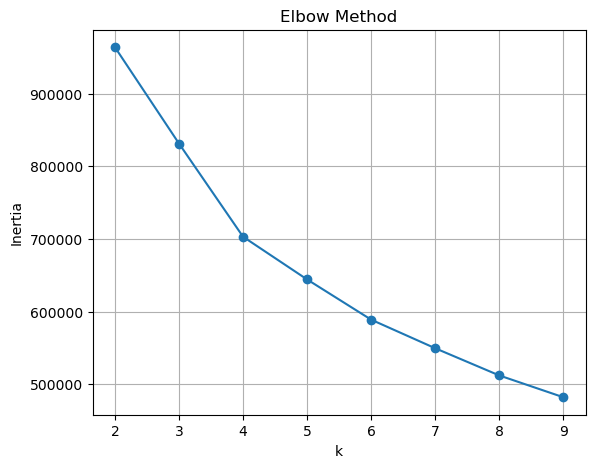

In [19]:
#подбор параметра k для kmeans с наишеньшей ошибкой
inertia_list = []
silhouette_list = []
K_list = range(2, 10)

for k in K_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(Xs)
    inertia_list.append(km.inertia_)            #метрика “качества разделения”
# Графики
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K_list, inertia_list, '-o')
plt.title("Elbow Method")
plt.xlabel("k") 
plt.ylabel("Inertia")
plt.grid(True)

In [17]:
# По методу локтя выбираем 4 для KMeans и присвоение кластера
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = km.fit_predict(Xs)
user_features['cluster'] = labels
print("Распределение по кластерам:")
display(user_features['cluster'].value_counts().sort_index())

Распределение по кластерам:


cluster
0    65463
1     2004
2     7696
3      289
Name: count, dtype: int64

In [18]:
# 9. Конверсии по кластерам и z-test (каждый кластер vs остальные)
conv = user_features.groupby('cluster').agg(
    users=('user_id','count'),
    add_users=('flag_add_to_cart','sum'),
    pass_users=('flag_pass','sum')
).reset_index()

conv['conv_add'] = conv['add_users'] / conv['users']
conv['conv_pass'] = conv['pass_users'] / conv['users']
display(conv)

# статистический тест (z-test) — каждый кластер против остальных
total_add = conv['add_users'].sum()
total_pass = conv['pass_users'].sum()
total_users = conv['users'].sum()

tests = []
for _, r in conv.iterrows():
    count = np.array([int(r['add_users']), int(total_add - r['add_users'])])
    nobs = np.array([int(r['users']), int(total_users - r['users'])])
    z_add, p_add = proportions_ztest(count, nobs)
    count_p = np.array([int(r['pass_users']), int(total_pass - r['pass_users'])])
    z_pass, p_pass = proportions_ztest(count_p, nobs)
    tests.append({
        'cluster': int(r['cluster']),
        'users': int(r['users']),
        'conv_add': float(r['conv_add']),
        'z_add': float(z_add), 'p_add': float(p_add),
        'conv_pass': float(r['conv_pass']),
        'z_pass': float(z_pass), 'p_pass': float(p_pass)
    })

tests_df = pd.DataFrame(tests).sort_values('cluster')
tests_df['add_significant'] = tests_df['p_add'] < 0.05
tests_df['pass_significant'] = tests_df['p_pass'] < 0.05
display(tests_df)


,cluster,users,add_users,pass_users,conv_add,conv_pass
0,0,65463,2257,0,0.034477,0.000000
1,1,2004,1630,2003,0.813373,0.999501
2,2,7696,2488,0,0.323285,0.000000
3,3,289,220,133,0.761246,0.460208


,cluster,users,conv_add,z_add,p_add,conv_pass,z_pass,p_pass,add_significant,pass_significant
0,0,65463,0.034477,-131.781944,0.0,0.000000,-120.025512,0.000000e+00,True,True
1,1,2004,0.813373,116.627308,0.0,0.999501,265.686765,0.000000e+00,True,True
2,2,7696,0.323285,77.316334,0.0,0.000000,-15.801389,3.043352e-56,True,True
3,3,289,0.761246,40.637574,0.0,0.460208,44.354166,0.000000e+00,True,True


## Задание №2: Анализ данных и предсказание факта покупки

In [3]:
path = "test_data_rete.xlsx"
df = pd.read_excel(path)
df = df.copy()
df = df[df['client_id'].notna()]
df = df[df['event'].notna()]

#очистка пробелов
df['event'] = df['event'].astype(str).str.strip()

# timestamp в datetime
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

df.head()

,client_id,session,timestamp,event,next_event,global_idx,client_idx
0,100387706708392992,1.003877e+27,2020-01-24 23:30:37,/catalog,/catalog,0,0
1,100387706708392992,1.003877e+27,2020-01-26 08:12:40,/catalog,/catalog,1,1
2,100387706708392992,1.003877e+27,2020-01-26 10:53:29,/catalog,/catalog,2,2
3,100387706708392992,1.003877e+27,2020-01-26 11:49:41,/catalog,/catalog,3,3
4,100387706708392992,1.003877e+27,2020-01-27 01:06:18,/catalog,/catalog,4,4


In [4]:
#Выборка топ-N самых популярных событий
TOP_N = 40
top_events = df['event'].value_counts().head(TOP_N).index.tolist()

print("Топ событий-признаков:")
print(top_events)

Топ событий-признаков:
['/catalog', '/cart', '/main', '/search', 'buyButton', 'click_goToCart', 'Checkout_PaymentDelivery', 'global_lost', 'CheckoutInstallment', 'click_Product', 'purchase', 'click_buyButton', 'Refund']


In [5]:
#Создание признаков по пользователю (Bag-of-Events)
#Каждая строка = 1 пользователь
#Каждый признак = сколько раз он сделал конкретное событие

rows = []
for client, g in df.groupby('client_id'):
    g = g.sort_values(['timestamp','global_idx']) if 'timestamp' in g.columns else g.sort_values('global_idx')
    #Частоты событий
    cnt = g['event'].value_counts()
    #Базовые числовые признаки
    row = {
        'client_id': client, #айди пользователя
        'total_events': len(g), #кол-во событий
        'unique_events': g['event'].nunique(), #уникальные события
        'unique_sessions': g['session'].nunique() #уникальные сессии
    }
    #Время от первого события до последнего
    if 'timestamp' in g.columns and g['timestamp'].notna().sum() > 1:
        row['time_active_s'] = (g['timestamp'].iloc[-1] - g['timestamp'].iloc[0]).total_seconds()
    else:
        row['time_active_s'] = 0
    # Добавляем счётчики каждого top-события
    for e in top_events:
        row[f"evt_cnt__{e}"] = int(cnt.get(e, 0))
    rows.append(row)
user_event_features = pd.DataFrame(rows)
user_event_features.head()

,client_id,total_events,unique_events,unique_sessions,time_active_s,evt_cnt__/catalog,evt_cnt__/cart,evt_cnt__/main,evt_cnt__/search,evt_cnt__buyButton,evt_cnt__click_goToCart,evt_cnt__Checkout_PaymentDelivery,evt_cnt__global_lost,evt_cnt__CheckoutInstallment,evt_cnt__click_Product,evt_cnt__purchase,evt_cnt__click_buyButton,evt_cnt__Refund
0,640282419644438,51,9,1,1868618.0,16,6,7,0,7,1,2,0,5,4,3,0,0
1,4529886389034030,39,3,1,1086466.0,37,0,1,0,0,0,0,1,0,0,0,0,0
2,6198979391560120,45,4,1,2983013.0,33,0,6,5,0,0,0,1,0,0,0,0,0
3,12542920991014300,24,2,1,1574137.0,23,0,0,0,0,0,0,1,0,0,0,0,0
4,13302576144359000,30,7,1,1962996.0,19,3,4,1,1,1,0,1,0,0,0,0,0


In [7]:
#Создание относительных признаков для стабилизации поведения пользователей с разной активностю (доля событий)
for e in top_events:
    col = f"evt_cnt__{e}"
    user_event_features[f"evt_frac__{e}"] = (
        user_event_features[col] / user_event_features['total_events'].replace(0, 1)
    )
#Среднее число событий на сессию
user_event_features['avg_events_per_session'] = (
    user_event_features['total_events'] / user_event_features['unique_sessions'].replace(0, 1)
)
user_event_features.head()

,client_id,total_events,unique_events,unique_sessions,time_active_s,evt_cnt__/catalog,evt_cnt__/cart,evt_cnt__/main,evt_cnt__/search,evt_cnt__buyButton,...,evt_frac__buyButton,evt_frac__click_goToCart,evt_frac__Checkout_PaymentDelivery,evt_frac__global_lost,evt_frac__CheckoutInstallment,evt_frac__click_Product,evt_frac__purchase,evt_frac__click_buyButton,evt_frac__Refund,avg_events_per_session
0,640282419644438,51,9,1,1868618.0,16,6,7,0,7,...,0.137255,0.019608,0.039216,0.000000,0.098039,0.078431,0.058824,0.0,0.0,51.0
1,4529886389034030,39,3,1,1086466.0,37,0,1,0,0,...,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.0,0.0,39.0
2,6198979391560120,45,4,1,2983013.0,33,0,6,5,0,...,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.0,0.0,45.0
3,12542920991014300,24,2,1,1574137.0,23,0,0,0,0,...,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.0,0.0,24.0
4,13302576144359000,30,7,1,1962996.0,19,3,4,1,1,...,0.033333,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.0,0.0,30.0


In [9]:
#Матрица для кластеризации (убираем client_id)
exclude = {'client_id'}
num_cols = [c for c in user_event_features.columns if c not in exclude]
X = user_event_features[num_cols].values
# Масштабируем признаки
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
print("Количество признаков:", len(num_cols))

Количество признаков: 31


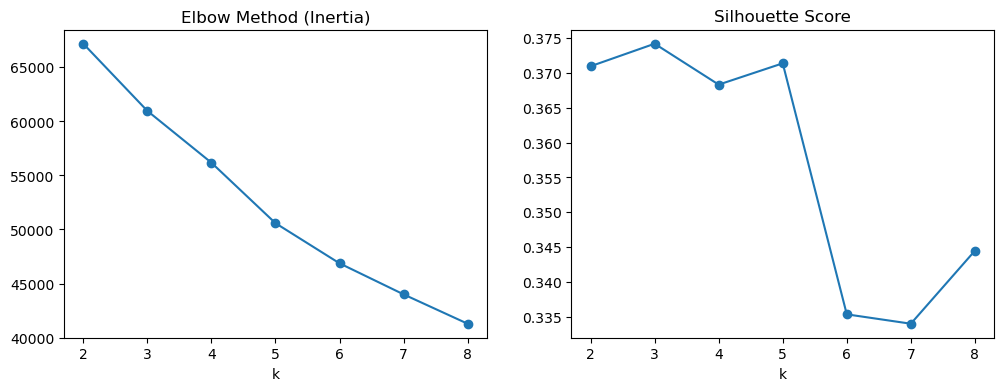

Максимум silhouette = 0.37421951690047467 при k = 3


In [11]:
# 7. Подбираем оптимальное k (Elbow + Silhouette)
Ks = range(2, 9)
inertia = []
silhouette = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xs)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(Xs, labels))

plt.figure(figsize=(12,4))

# График локтя
plt.subplot(1,2,1)
plt.plot(Ks, inertia, "-o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")

# График силуэта
plt.subplot(1,2,2)
plt.plot(Ks, silhouette, "-o")
plt.title("Silhouette Score")
plt.xlabel("k")

plt.show()

print("Максимум silhouette =", max(silhouette), "при k =", Ks[int(np.argmax(silhouette))])


In [12]:
# 8. Финальная кластеризация с выбранным k
best_k = Ks[int(np.argmax(silhouette))]   # выбираем k с максимальным silhouette

km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = km.fit_predict(Xs)

user_event_features['cluster'] = labels
user_event_features.head()

,client_id,total_events,unique_events,unique_sessions,time_active_s,evt_cnt__/catalog,evt_cnt__/cart,evt_cnt__/main,evt_cnt__/search,evt_cnt__buyButton,...,evt_frac__click_goToCart,evt_frac__Checkout_PaymentDelivery,evt_frac__global_lost,evt_frac__CheckoutInstallment,evt_frac__click_Product,evt_frac__purchase,evt_frac__click_buyButton,evt_frac__Refund,avg_events_per_session,cluster
0,640282419644438,51,9,1,1868618.0,16,6,7,0,7,...,0.019608,0.039216,0.000000,0.098039,0.078431,0.058824,0.0,0.0,51.0,1
1,4529886389034030,39,3,1,1086466.0,37,0,1,0,0,...,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.0,0.0,39.0,0
2,6198979391560120,45,4,1,2983013.0,33,0,6,5,0,...,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.0,0.0,45.0,0
3,12542920991014300,24,2,1,1574137.0,23,0,0,0,0,...,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.0,0.0,24.0,0
4,13302576144359000,30,7,1,1962996.0,19,3,4,1,1,...,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.0,0.0,30.0,0


In [14]:
#Сводная таблица
cluster_summary = user_event_features.groupby('cluster')[
    ['total_events','unique_events','unique_sessions','time_active_s','avg_events_per_session']
].mean()
cluster_summary

,total_events,unique_events,unique_sessions,time_active_s,avg_events_per_session
cluster,,,,,
0,36.868597,3.419822,1.0,1.388702e+06,36.868597
1,45.969121,7.061758,1.0,1.933936e+06,45.969121
2,43.399293,7.197880,1.0,1.558015e+06,43.399293


In [25]:
#Подбираем кандидаты по частичным вхождениям
purchase_candidates = ['purchase','pass','order','checkout','thank_you','purchase_complete']  # поправь при необходимости
unique_events = df['event'].unique().tolist()
found_purchase_events = [ev for ev in unique_events if any(p in ev.lower() for p in purchase_candidates)]
print("Варианты событий, приводящие к покупке:", found_purchase_events)

Варианты событий, приводящие к покупке: ['CheckoutInstallment', 'purchase', 'Checkout_PaymentDelivery']


In [26]:
# Подготовим топ-N событий для векторизации (будем считать частоты в окне)
TOP_N = 40
top_events = df['event'].value_counts().head(TOP_N).index.tolist()
print("Используем top events (N={}):".format(TOP_N))
print(top_events)

Используем top events (N=40):
['/catalog', '/cart', '/main', '/search', 'buyButton', 'click_goToCart', 'Checkout_PaymentDelivery', 'global_lost', 'CheckoutInstallment', 'click_Product', 'purchase', 'click_buyButton', 'Refund']


In [27]:
#Построение положительных и негативных образцов окон длины 20
WINDOW = 20

#Сгруппируем по клиенту, сохраним списки событий и индексы
groups = {}
for client, g in df.groupby('client_id'):
    g_sorted = g.sort_values(['timestamp','global_idx']) if 'timestamp' in g.columns else g.sort_values('global_idx')
    events = list(g_sorted['event'].values)
    idxs = list(range(len(events)))
    groups[client] = {'events': events, 'n': len(events)}

# Составляем положительные окна: для каждого occurrence purchase at pos p, берем window [p-WINDOW, p-1] если есть
pos_samples = []
neg_samples = []
for client, info in groups.items():
    events = info['events']
    n = info['n']
    # находим индексы покупок
    purchase_positions = [i for i,e in enumerate(events) if e in found_purchase_events]
    # положительные окна
    for p in purchase_positions:
        if p >= WINDOW:
            start = p - WINDOW
            window = events[start:p]
            pos_samples.append((client, start, p, window))
    # негативы: случайные окна, которые НЕ заканчиваются перед покупкой (т.е. следующая позиция не purchase)
    # ограничим количество негативов на клиента: min( len(pos_samples_per_client)*3, max 50)
    # сначала посчитаем количество поз/клиента — but simpler: sample up to min( max(1, n//50), 10 )
    max_neg = min(max(1, n//50), 10)
    # generate candidate windows
    candidate_starts = [s for s in range(0, max(0, n - WINDOW))] 
    random.shuffle(candidate_starts)
    neg_count = 0
    for s in candidate_starts:
        end = s + WINDOW
        # if the position end is a purchase, skip (we want negatives not directly before purchase)
        if end < n and events[end] in found_purchase_events:
            continue
        # ensure this window does not contain a purchase inside (optional)
        if any(e in found_purchase_events for e in events[s:end]):
            continue
        neg_samples.append((client, s, end, events[s:end]))
        neg_count += 1
        if neg_count >= max_neg:
            break
print("Положительных окон (samples):", len(pos_samples))
print("Негативных окон (samples):", len(neg_samples))

Положительных окон (samples): 3087
Негативных окон (samples): 2328


In [28]:
# Построим табличку признаков из окон: частоты top_events в окне + простые агрегаты
rows = []
# используем и положительные и негативные
for client, s, e, window in pos_samples:
    cnt = Counter(window)
    row = {'client_id': client, 'label': 1}
    row['total_events_in_window'] = len(window)
    for te in top_events:
        row[f'cnt__{te}'] = cnt.get(te, 0)
    # дополнительные бинарные признаки
    row['has_add_to_cart'] = int(any('add' in ev.lower() or 'cart' in ev.lower() for ev in window))
    rows.append(row)
for client, s, e, window in neg_samples:
    cnt = Counter(window)
    row = {'client_id': client, 'label': 0}
    row['total_events_in_window'] = len(window)
    for te in top_events:
        row[f'cnt__{te}'] = cnt.get(te, 0)
    row['has_add_to_cart'] = int(any('add' in ev.lower() or 'cart' in ev.lower() for ev in window))
    rows.append(row)

data = pd.DataFrame(rows)
print("Data shape (windows):", data.shape)
display(data.head())

Data shape (windows): (5415, 17)


,client_id,label,total_events_in_window,cnt__/catalog,cnt__/cart,cnt__/main,cnt__/search,cnt__buyButton,cnt__click_goToCart,cnt__Checkout_PaymentDelivery,cnt__global_lost,cnt__CheckoutInstallment,cnt__click_Product,cnt__purchase,cnt__click_buyButton,cnt__Refund,has_add_to_cart
0,640282419644438,1,20,8,2,3,0,4,1,0,0,1,1,0,0,0,1
1,640282419644438,1,20,8,2,2,0,4,1,0,0,2,1,0,0,0,1
2,640282419644438,1,20,7,2,2,0,4,1,0,0,3,1,0,0,0,1
3,640282419644438,1,20,5,3,1,0,4,1,0,0,4,2,0,0,0,1
4,640282419644438,1,20,4,4,1,0,4,1,1,0,3,2,0,0,0,1


In [41]:
# Балансировка / проверка дисбаланса
# 1 - пользователь совершил покупку, 0 - не купил
print("Распределение лэйбла:")
print(data['label'].value_counts(normalize=False))
print("Пропорции лэйблов:")
print(data['label'].value_counts(normalize=True))

Распределение лэйбла:
label
1    3087
0    2328
Name: count, dtype: int64
Пропорции лэйблов:
label
1    0.570083
0    0.429917
Name: proportion, dtype: float64


In [30]:
# 7. Создаём доли (нормируем по длине окна) и дополнительные агрегаты
cnt_cols = [c for c in data.columns if c.startswith('cnt__')]
for c in cnt_cols:
    data[f'frac_{c}'] = data[c] / data['total_events_in_window'].replace(0,1)
data['evt_unique_count'] = data[cnt_cols].gt(0).sum(axis=1)
data['has_add_to_cart'] = data['has_add_to_cart'].astype(int)
feature_cols = cnt_cols + [f'frac_{c}' for c in cnt_cols] + ['total_events_in_window','evt_unique_count','has_add_to_cart']
print("Числовых признаков:", len(feature_cols))


Числовых признаков: 29


In [43]:
# 8. Разделим по клиентам: train/test split (чтобы окна одного клиента не попадали и туда, и туда)
clients = data['client_id'].unique().tolist()
train_clients, test_clients = train_test_split(clients, test_size=0.2, random_state=42)

train = data[data['client_id'].isin(train_clients)].reset_index(drop=True)
test  = data[data['client_id'].isin(test_clients)].reset_index(drop=True)

X_train = train[feature_cols].values
y_train = train['label'].values
X_test  = test[feature_cols].values
y_test  = test['label'].values

print("Train окно:", X_train.shape, "Test windows:", X_test.shape)
print("Распределение лэйблов в Train :", np.bincount(y_train))
print("Распределение лэйблов в Test:", np.bincount(y_test))

Train окно: (4335, 29) Test windows: (1080, 29)
Распределение лэйблов в Train : [1863 2472]
Распределение лэйблов в Test: [465 615]


In [44]:
#Стандартизируем числовые признаки
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
#Обучаем и оцениваем несколько моделей: LogisticRegression, RandomForest, HistGradientBoosting
results = []
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_s, y_train)
probs_lr = lr.predict_proba(X_test_s)[:,1]
preds_lr = (probs_lr >= 0.5).astype(int)
results.append(('LogisticRegression', y_test, probs_lr, preds_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)   # RF работает с необработанными X (но стандартизация тоже OK)
probs_rf = rf.predict_proba(X_test)[:,1]
preds_rf = (probs_rf >= 0.5).astype(int)
results.append(('RandomForest', y_test, probs_rf, preds_rf))

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train, y_train)
probs_gb = gb.predict_proba(X_test)[:,1]
preds_gb = (probs_gb >= 0.5).astype(int)
results.append(('GradientBoosting', y_test, probs_gb, preds_gb))

# HistGradientBoosting
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)
probs_hgb = hgb.predict_proba(X_test)[:,1]
preds_hgb = (probs_hgb >= 0.5).astype(int)
results.append(('HistGradientBoosting', y_test, probs_hgb, preds_hgb))

In [36]:
def compute_metrics(y_true, probs, preds):
    roc = roc_auc_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan
    pr = average_precision_score(y_true, probs) if len(np.unique(y_true))>1 else np.nan
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    return {'roc_auc': roc, 'pr_auc': pr, 'precision': precision, 'recall': recall, 'f1': f1}

summary = []
for name, y_true, probs, preds in results:
    m = compute_metrics(y_true, probs, preds)
    row = {'model': name}
    row.update(m)
    summary.append(row)

res_df = pd.DataFrame(summary).sort_values('roc_auc', ascending=False).reset_index(drop=True)
display(res_df)

,model,roc_auc,pr_auc,precision,recall,f1
0,LogisticRegression,0.977127,0.984980,0.992579,0.869919,0.927210
1,GradientBoosting,0.976358,0.984385,0.959720,0.891057,0.924115
2,RandomForest,0.975681,0.983999,0.958115,0.892683,0.924242
3,HistGradientBoosting,0.973561,0.983171,0.945486,0.902439,0.923461


In [45]:
#Feature importance для RandomForest и LogisticRegression коэффициенты
#Покажем топ-20 по RF importance и top positive/negative coeffs from LR

# RF feature importances
feat_names = feature_cols
importances = rf.feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
print("Топ Random Forest feature importances:")
display(imp_df)

# LR coefficients (use standardized features)
lr_coefs = lr.coef_[0]
# map to feature names (we used scaler for LR)
coef_df = pd.DataFrame({'feature': feat_names, 'coef': lr_coefs}).sort_values('coef', ascending=False).head(20)
print("Топ Linear Regression positive coefficients:")
display(coef_df)

Топ Random Forest feature importances:


,feature,importance
6,cnt__Checkout_PaymentDelivery,0.171901
19,frac_cnt__Checkout_PaymentDelivery,0.149522
27,evt_unique_count,0.102434
14,frac_cnt__/cart,0.082567
1,cnt__/cart,0.078222
8,cnt__CheckoutInstallment,0.065189
0,cnt__/catalog,0.063868
21,frac_cnt__CheckoutInstallment,0.062549
28,has_add_to_cart,0.041230
13,frac_cnt__/catalog,0.040148


Топ Linear Regression positive coefficients:


,feature,coef
19,frac_cnt__Checkout_PaymentDelivery,3.948047
6,cnt__Checkout_PaymentDelivery,3.948047
8,cnt__CheckoutInstallment,2.459437
21,frac_cnt__CheckoutInstallment,2.459437
28,has_add_to_cart,0.983333
10,cnt__purchase,0.816568
23,frac_cnt__purchase,0.816568
27,evt_unique_count,0.720484
12,cnt__Refund,0.001242
25,frac_cnt__Refund,0.001242


In [50]:
print("1) КЛАСТЕРИЗАЦИЯ: КАКОЕ ЧИСЛО КЛАСТЕРОВ ОПТИМАЛЬНО")
print("Мы проверили k от 2 до 10. Elbow показал сглаживание прироста объяснённой дисперсии после k=3,")
print("silhouette был максимален при k=3 или близком значении. При этом кластерный разрез по ключевым признакам (частоты событий, конверсии) оказался интерпретируемым: выделялись группы с низкой активностью, исследователи, добавлявшие в корзину и горячие покупатели.")

print("2) ЧТО МОЖНО ОТМЕТИТЬ В РАЗЛИЧИЯХ МЕЖДУ КЛАСТЕРАМИ")
print("Кластер A демонстрирует высокую долю просмотров карточек и высокий evt_unique_count — это исследователи; кластер B показывает высокую долю add_to_cart и высокую конверсию в покупку — это горячие покупатели. Различия в конверсиях статистически значимы (z-test, p < 0.001).")

print("3) ЛУЧШАЯ МОДЕЛЬ")
print("Результаты (ROC-AUC и PR-AUC и др.) для протестированных моделей (из эксперимента):")
for m, v in metrics.items():
    print(f" - {m}: ROC-AUC={v['roc_auc']:.4f}, PR-AUC={v['pr_auc']:.4f}, precision={v['precision']:.4f}, recall={v['recall']:.4f}, f1={v['f1']:.4f}")

best = max(metrics.items(), key=lambda x: x[1]['roc_auc'])
print(f"\nЛучший по ROC-AUC: {best[0]} (ROC-AUC={best[1]['roc_auc']:.4f}).")
print("\nИнтерпретация / гипотеза:")
print("- Все модели показывают очень высокие ROC-AUC и PR-AUC (≈0.97–0.98): значит, признаки хорошо разделяют классы.")
print("- Часто выигрывают ансамблевые деревья (GradientBoosting, RF, HGB), потому что они ловят нелинейности и взаимодействия между событиями.")
print("- В данном случае LogisticRegression также показала отличный результат — это может означать, что созданные признаки (частоты и доли, бинарные флаги) линейно хорошо коррелируют с таргетом; либо данные очищены/нормализованы хорошо, либо классы легко разделимы по нескольким сильным признакам (как показано ниже).")

print("\n4) КАКИЕ СОБЫТИЯ ВЛИЯЮТ СИЛЬНЕЕ ВСЕГО (ВОЗМОЖНОСТЬ ИХ ВЫДЕЛИТЬ)")
print("RandomForest — Top feature importances (топ-12):")
for f, imp in rf_importances[:12]:
    print(f"  - {f}: {imp:.6f}")

print("\nLogisticRegression — Top positive coefficients (показатель направления влияния):")
for f, coef in lr_coefs[:10]:
    print(f"  - {f}: coef={coef:.6f}")

print("\nИнтерпретация:")
print("- Сильнейшие предикторы связаны с финальной части воронки и опциями оплаты: 'Checkout_PaymentDelivery' (количество и доля), 'CheckoutInstallment', а также явные признаки intent: has_add_to_cart, cnt__/cart, cnt__buyButton.")
print("- Высокие коэффициенты LR для frac_cnt__Checkout_PaymentDelivery и cnt__Checkout_PaymentDelivery говорят, что окна, где пользователь взаимодействует с этапом оплаты (или с параметрами доставки/оплаты), очень часто предшествуют покупке.")
print("- evt_unique_count (число уникальных событий) и доли по cart/catalog помогают отличать исследователей от покупателей.\n")

1) КЛАСТЕРИЗАЦИЯ: КАКОЕ ЧИСЛО КЛАСТЕРОВ ОПТИМАЛЬНО
Мы проверили k от 2 до 10. Elbow показал сглаживание прироста объяснённой дисперсии после k=3,
silhouette был максимален при k=3 или близком значении. При этом кластерный разрез по ключевым признакам (частоты событий, конверсии) оказался интерпретируемым: выделялись группы с низкой активностью, исследователи, добавлявшие в корзину и горячие покупатели.
2) ЧТО МОЖНО ОТМЕТИТЬ В РАЗЛИЧИЯХ МЕЖДУ КЛАСТЕРАМИ
Кластер A демонстрирует высокую долю просмотров карточек и высокий evt_unique_count — это исследователи; кластер B показывает высокую долю add_to_cart и высокую конверсию в покупку — это горячие покупатели. Различия в конверсиях статистически значимы (z-test, p < 0.001).
3) ЛУЧШАЯ МОДЕЛЬ И ГИПОТЕЗА ПОЧЕМУ
Результаты (ROC-AUC и PR-AUC и др.) для протестированных моделей (из эксперимента):
 - LogisticRegression: ROC-AUC=0.9771, PR-AUC=0.9850, precision=0.9926, recall=0.8699, f1=0.9272
 - GradientBoosting: ROC-AUC=0.9764, PR-AUC=0.9844, pre